In [1]:
import warnings
warnings.simplefilter(action='ignore', category=UserWarning) # Ignore User Warning regarding Shapely

import matplotlib.pyplot as plt
import contextily
import pandas as pd
import geopandas as gpd
import pymssql
from shapely import wkb
from tobler.area_weighted import area_interpolate
import os

# Rasterio Installation bug where the Environment variable 'PROJ_LIB' isn't looking in the right file for 'Proj.db' SQLlite Database
# After installation of contextily (and by extension rasterio), you need to find the folder where rasterio is storing the 'Proj.db' file and set the environment variable 'PROJ_LIB' to use the right file path
os.environ['PROJ_LIB'] = '/Users/ahadhussain/opt/anaconda3/lib/python3.9/site-packages/rasterio/proj_data/'

In [2]:
database = 'Pushing-P-DB'
table1 = 'dbo.NJ_Cities'
table2 = 'dbo.NJ_Census_Tracts'
user = 'pushing_p'
password  = 't3stP@ssword'
server = 'gen10-data-fundamentals-22-02-sql-server.database.windows.net'


# Retrieve Training Data for Geographically Weighted Regression Model
conn = pymssql.connect(server, user, password, database)

# Query select all rows from SQL tables to insert into their respective DataFrames
query1 = f'SELECT * FROM {table1}'
query2 = f'SELECT * FROM {table2}'
df = pd.read_sql(query1, conn)
tract_info = pd.read_sql(query2, conn)

# Use a function to convert wkb_hex string in SQL database to polygonal geometries (WKB stands for Well-Known Binary, which is commonly used for encoding geographic polygons)
# WKT, well-known text, markup can also be used

def convert_to_polygon(line):
    return wkb.loads(line, hex=True)
df['geometry'] = df['geometry'].apply(convert_to_polygon)
tract_info['geometry'] = tract_info['geometry'].apply(convert_to_polygon)

# Convert from pandas to geopandas dataframes
df = gpd.GeoDataFrame(df, geometry=df['geometry'], crs = 'epsg:4269')
tract_info = gpd.GeoDataFrame(tract_info, geometry=tract_info['geometry'], crs = 'epsg:4269')

# Add % Uninsured Column
df['% Uninsured'] = df['Uninsured Population']/df['City Population']*100
tract_info['% Uninsured'] = tract_info['Uninsured Population']/tract_info['City Population']*100


In [3]:
df.head()

,State,County,City,Unemployment Rate (16 & Over),Median Household Income,City Population,Uninsured Population,"NUI, Under 6 years","NUI, 6-18 years","NUI, 19 to 25 years",...,"NUI, Men","NUI, Women","NUI, White","NUI, African American","NUI, American Indian & Alaska Natives","NUI, Asians","NUI, Native Hawaiians & Pacific Islanders","NUI, Other Races",geometry,% Uninsured
0,New Jersey,Monmouth County,Millstone Township,3.8,177500,10418,144,0,6,0,...,86,58,123,1,0,19,0,1,"POLYGON ((-74.54327 40.21669, -74.48148 40.242...",1.382223
1,New Jersey,Monmouth County,Sea Bright Borough,5.4,91601,1293,11,0,0,0,...,0,11,11,0,0,0,0,0,"POLYGON ((-73.98849 40.35209, -73.98293 40.353...",0.850735
2,New Jersey,Ocean County,Toms River Township,4.6,79193,91897,5169,105,497,715,...,2750,2419,3721,289,4,307,0,613,"POLYGON ((-74.26779 39.99067, -74.26646 39.990...",5.624776
3,New Jersey,Hunterdon County,Union Township,4.1,109577,4726,53,0,7,0,...,19,34,37,0,0,0,0,16,"POLYGON ((-75.04588 40.63111, -74.97916 40.657...",1.121456
4,New Jersey,Monmouth County,Sea Girt Borough,5.7,164602,1725,79,0,44,0,...,27,52,79,0,0,0,0,0,"POLYGON ((-74.04473 40.13486, -74.04219 40.139...",4.579710


In [4]:
df.shape

(559, 25)

In [5]:
tract_info.head()

,State,County,Census Tract,Unemployment Rate (16 & Over),Median Household Income,City Population,Uninsured Population,"NUI, Under 6 years","NUI, 6-18 years","NUI, 19 to 25 years",...,"NUI, Men","NUI, Women","NUI, White","NUI, African American","NUI, American Indian & Alaska Natives","NUI, Asians","NUI, Native Hawaiians & Pacific Islanders","NUI, Other Races",geometry,% Uninsured
0,New Jersey,Mercer County,Census Tract 30.09,11.5,69052.0,5990.0,444.0,0.0,12.0,45.0,...,398.0,46.0,403.0,18.0,0.0,23.0,0.0,0.0,"POLYGON ((-74.69241 40.21257, -74.68845 40.218...",7.412354
1,New Jersey,Atlantic County,Census Tract 101.01,2.9,98850.0,3270.0,82.0,0.0,0.0,0.0,...,73.0,9.0,81.0,1.0,0.0,0.0,0.0,0.0,"POLYGON ((-74.40783 39.40556, -74.40551 39.407...",2.507645
2,New Jersey,Hudson County,Census Tract 74,1.7,190975.0,4972.0,8.0,0.0,0.0,0.0,...,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((-74.04147 40.71347, -74.03645 40.712...",0.160901
3,New Jersey,Middlesex County,Census Tract 82.05,5.1,48661.0,3431.0,43.0,0.0,0.0,0.0,...,7.0,36.0,14.0,29.0,0.0,0.0,0.0,0.0,"POLYGON ((-74.45673 40.31241, -74.45642 40.313...",1.253279
4,New Jersey,Atlantic County,Census Tract 101.05,5.0,62000.0,2495.0,176.0,11.0,18.0,9.0,...,66.0,110.0,140.0,0.0,0.0,0.0,0.0,20.0,"POLYGON ((-74.42199 39.38523, -74.41318 39.389...",7.054108


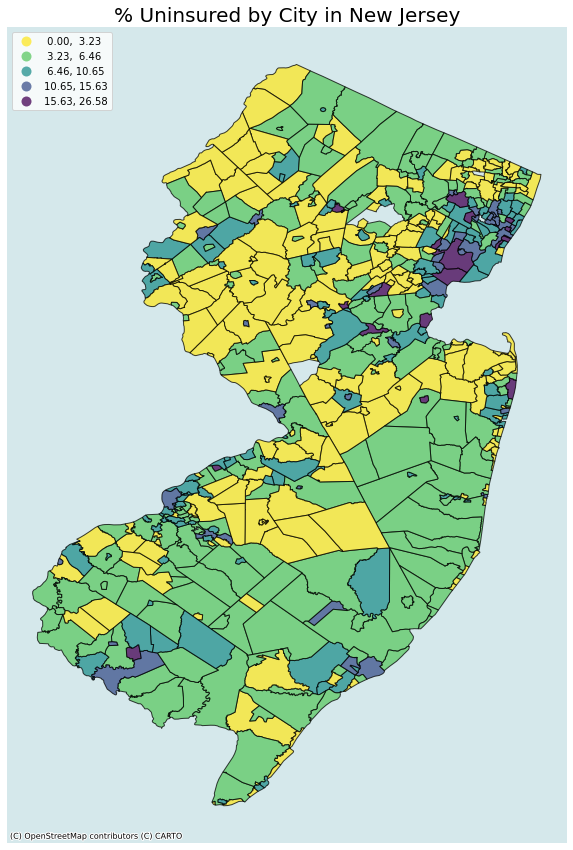

In [6]:
# Set up figure and a single axis
f, ax = plt.subplots(1, figsize=(15, 15))

# Build choropleth
df.plot(
    column='% Uninsured', 
    cmap='viridis_r', 
    scheme='natural_breaks',
    k=5, 
    edgecolor='black', 
    linewidth=1, 
    alpha=0.75, 
    legend=True,
    legend_kwds=dict(loc=2),
    ax=ax
)
# Add basemap
contextily.add_basemap(
    ax, 
    source=contextily.providers.CartoDB.Voyager,
)

plt.title('% Uninsured by City in New Jersey', fontsize=20)
ax.set_axis_off();

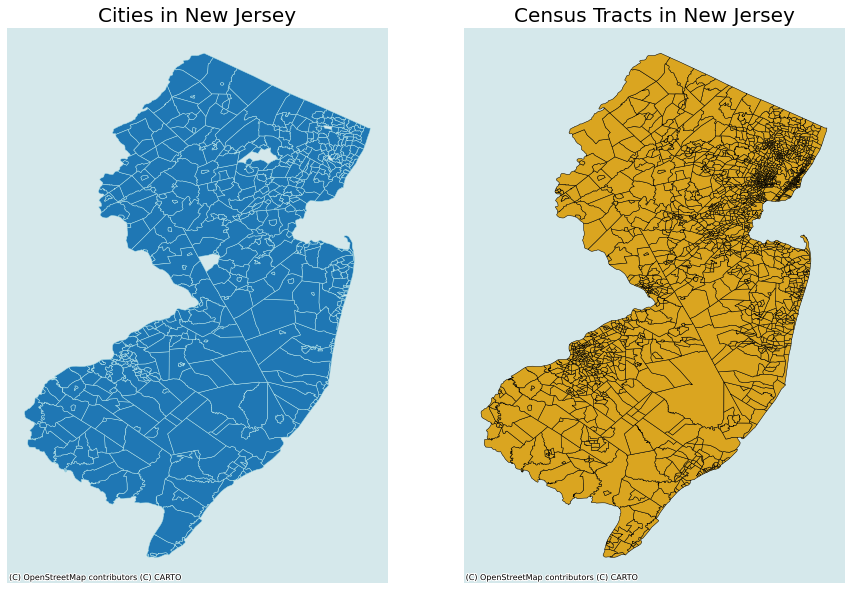

In [7]:
fig, ax = plt.subplots(1,2, figsize=(15,20))

df.plot(ax=ax[0], edgecolor = 'powderblue', linewidth = 0.5)
tract_info.plot(ax=ax[1], color = 'goldenrod',edgecolor = 'black', linewidth = 0.5)


# Add basemap
contextily.add_basemap(
    ax[0], 
    source=contextily.providers.CartoDB.Voyager,
)

contextily.add_basemap(
    ax[1], 
    source=contextily.providers.CartoDB.Voyager
)
ax[0].set_title('Cities in New Jersey', fontsize=20)
ax[1].set_title('Census Tracts in New Jersey', fontsize=20)
ax[0].axis('off')
ax[1].axis('off');


#### Areal Interpolation:
- Areal interpolation is the process making estimates from a source set of polygons to an overlapping but incongruent set of target polygons. 

- The simplest technique available in `tobler` is **simple areal interpolation** in which variables from the source data are weighted according to the overlap between source and target polygons, then reaggregated to fit the target polygon geometries

In [8]:
# Drop rows with null values (about 175 counties are missing healthcare information so we drop those from our analysis)
tract_info.dropna(inplace=True)
tract_info.shape

(1809, 25)

In [9]:
extensive_variables = list(df.drop(['State','County','City','geometry','Unemployment Rate (16 & Over)', '% Uninsured'], axis=1).columns)
results = area_interpolate(source_df=df, target_df=tract_info, intensive_variables = ['Unemployment Rate (16 & Over)'], extensive_variables=extensive_variables)

In [10]:
results.head()

,Median Household Income,City Population,Uninsured Population,"NUI, Under 6 years","NUI, 6-18 years","NUI, 19 to 25 years","NUI, 26 to 34 years","NUI, 35 to 44 years","NUI, 45 to 54 years","NUI, 55 to 64 years",...,"NUI, Men","NUI, Women","NUI, White","NUI, African American","NUI, American Indian & Alaska Natives","NUI, Asians","NUI, Native Hawaiians & Pacific Islanders","NUI, Other Races",Unemployment Rate (16 & Over),geometry
0,3689.872859,3930.433919,231.399421,1.723477,15.057744,31.975028,71.932474,54.561643,34.650952,20.182819,...,128.353658,103.045763,142.277535,51.795010,0.000000,8.617383,0.453546,20.500302,5.6,"POLYGON ((-74.69241 40.21257, -74.68845 40.218..."
1,54154.603670,6243.714013,231.488303,7.907986,12.940340,23.723957,93.458011,44.572282,18.691602,30.194126,...,124.371045,107.117258,192.667283,0.718908,0.000000,12.221432,0.000000,14.378155,5.9,"POLYGON ((-74.40783 39.40556, -74.40551 39.407..."
2,1986.980754,6796.631370,708.039293,17.648997,47.098649,93.937372,196.010437,132.614408,108.467253,88.167007,...,393.294513,314.744780,207.707122,183.118092,9.045436,131.522717,0.000000,132.354482,5.3,"POLYGON ((-74.04147 40.71347, -74.03645 40.712..."
3,13941.740525,6454.272090,118.296028,0.000000,11.363412,9.760879,9.323825,27.534420,25.640518,23.163877,...,68.471839,49.824189,77.941349,4.224858,0.000000,36.129821,0.000000,0.000000,4.9,"POLYGON ((-74.45673 40.31241, -74.45642 40.313..."
4,11610.092605,1338.576833,49.628295,1.695377,2.774253,5.086130,20.036268,9.555759,4.007254,6.473256,...,26.663649,22.964646,41.305537,0.154125,0.000000,2.620127,0.000000,3.082503,5.9,"POLYGON ((-74.42199 39.38523, -74.41318 39.389..."


In [11]:
# Create Uninsurance rate columns

results['% Uninsured'] = results['Uninsured Population']/results['City Population']*100
results['% African'] = results['NUI, African American']/results['Uninsured Population']*100
tract_info['% African'] = tract_info['NUI, African American']/tract_info['Uninsured Population']*100
results['% White'] = results['NUI, White']/results['Uninsured Population']*100
tract_info['% White'] = tract_info['NUI, White']/tract_info['Uninsured Population']*100

results.shape

(1809, 24)

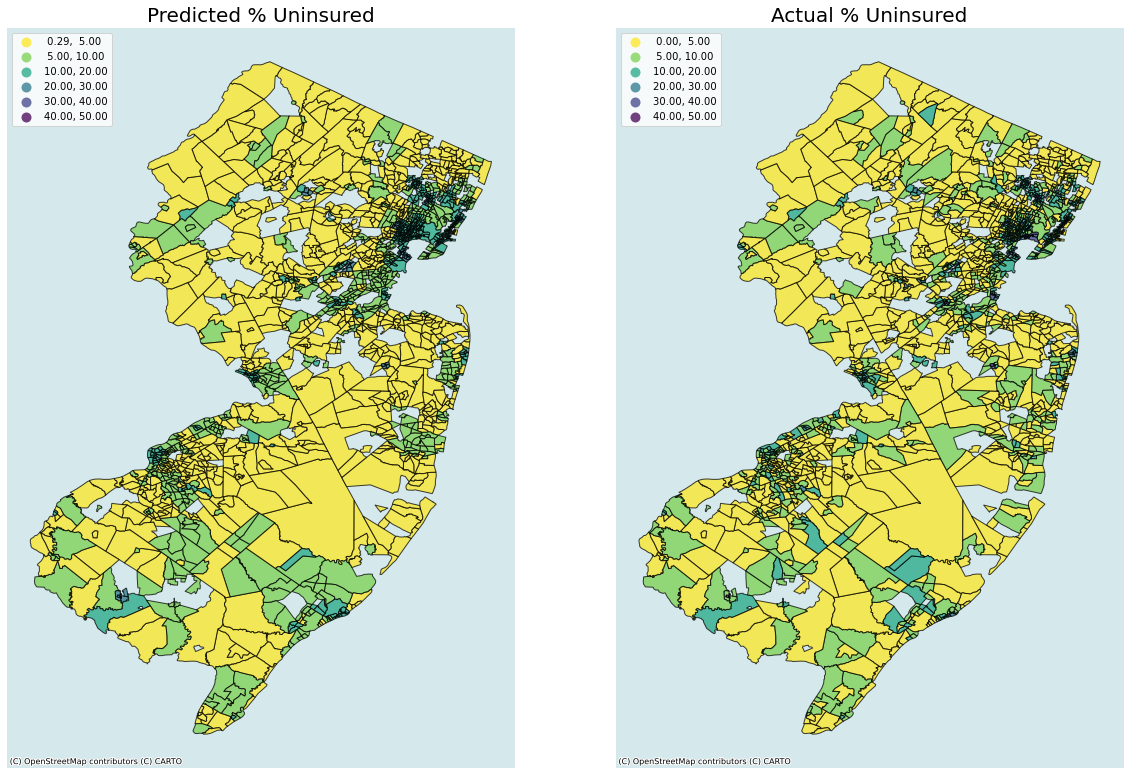

In [12]:
# Set up figure and a single axis
f, ax = plt.subplots(1,2, figsize=(20, 20))

# Build Predicted choropleth
results.plot(
    column='% Uninsured', 
    cmap='viridis_r', 
    scheme="User_Defined",
    classification_kwds=dict(bins=[5,10,20,30,40,50]),
    edgecolor='black', 
    linewidth=1, 
    alpha=0.75, 
    legend=True,
    legend_kwds=dict(loc=2),
    ax=ax[0]
)

# Build choropleth
tract_info.plot(
    column='% Uninsured', 
    cmap='viridis_r', 
    scheme="User_Defined",
    classification_kwds=dict(bins=[5,10,20,30,40,50]),
    edgecolor='black', 
    linewidth=1, 
    alpha=0.75, 
    legend=True,
    legend_kwds=dict(loc=2),
    ax=ax[1]
)


# Add basemap
contextily.add_basemap(
    ax[0], 
    source=contextily.providers.CartoDB.Voyager,
)

contextily.add_basemap(
    ax[1], 
    source=contextily.providers.CartoDB.Voyager
)

ax[0].set_title('Predicted % Uninsured',fontsize=20)
ax[1].set_title('Actual % Uninsured',fontsize=20)
ax[0].axis('off')
ax[1].axis('off');

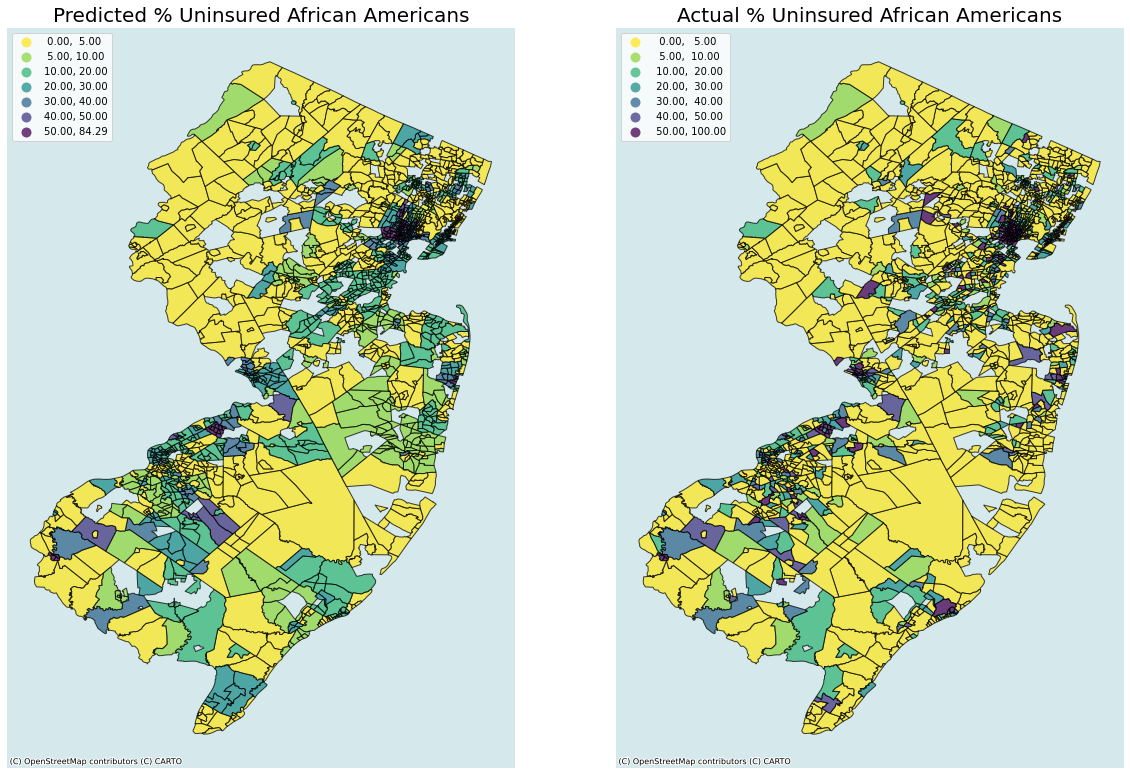

In [13]:
# Set up figure and a single axis
f, ax = plt.subplots(1,2, figsize=(20, 20))

# Build Predicted choropleth
results.plot(
    column='% African', 
    cmap='viridis_r', 
    scheme="User_Defined",
    classification_kwds=dict(bins=[5,10,20,30,40,50]),
    edgecolor='black', 
    linewidth=1, 
    alpha=0.75, 
    legend=True,
    legend_kwds=dict(loc=2),
    ax=ax[0]
)

# Build choropleth
tract_info.plot(
    column='% African', 
    cmap='viridis_r', 
    scheme="User_Defined",
    classification_kwds=dict(bins=[5,10,20,30,40,50]),
    edgecolor='black', 
    linewidth=1, 
    alpha=0.75, 
    legend=True,
    legend_kwds=dict(loc=2),
    ax=ax[1]
)


# Add basemap
contextily.add_basemap(
    ax[0], 
    source=contextily.providers.CartoDB.Voyager,
)

contextily.add_basemap(
    ax[1], 
    source=contextily.providers.CartoDB.Voyager
)

ax[0].set_title('Predicted % Uninsured African Americans',fontsize=20)
ax[1].set_title('Actual % Uninsured African Americans',fontsize=20)
ax[0].axis('off')
ax[1].axis('off');

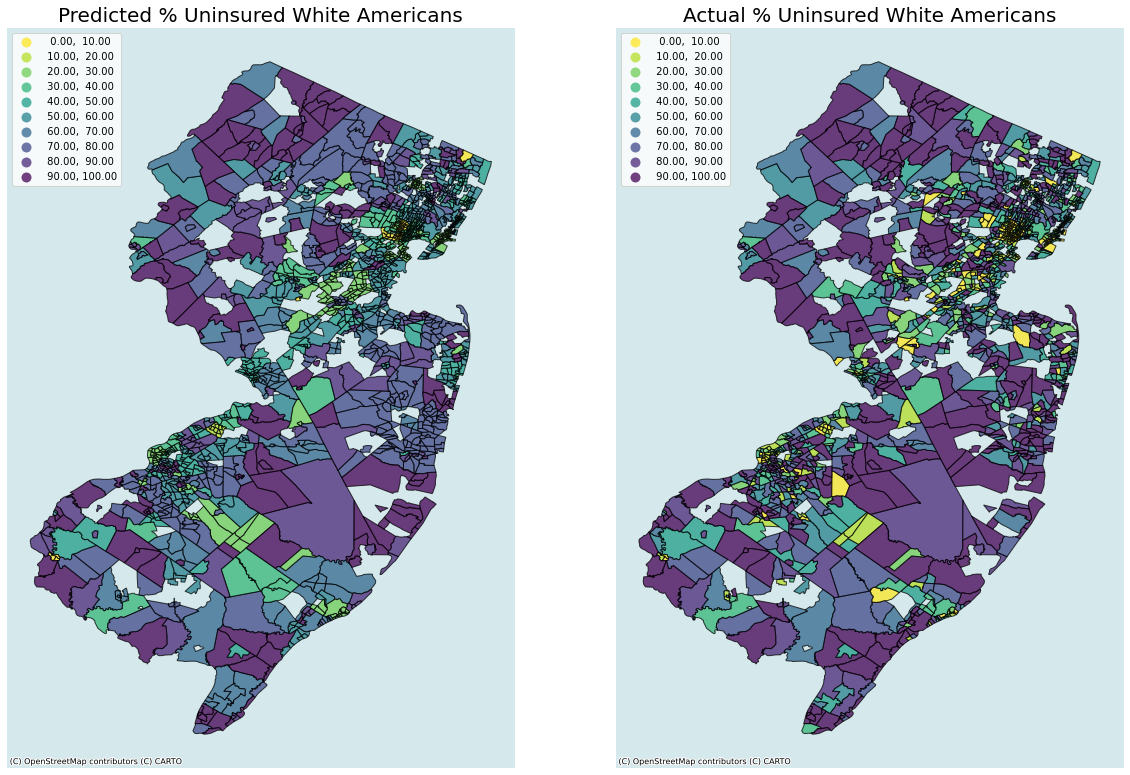

In [14]:
# Set up figure and a single axis
f, ax = plt.subplots(1,2, figsize=(20, 20))

# Build Predicted choropleth
results.plot(
    column='% White', 
    cmap='viridis_r', 
    scheme="User_Defined",
    classification_kwds=dict(bins=[10,20,30,40,50,60,70,80,90,100]),
    edgecolor='black', 
    linewidth=1, 
    alpha=0.75, 
    legend=True,
    legend_kwds=dict(loc=2),
    ax=ax[0]
)

# Build choropleth
tract_info.plot(
    column='% White', 
    cmap='viridis_r', 
    scheme="User_Defined",
    classification_kwds=dict(bins=[10,20,30,40,50,60,70,80,90,100]),
    edgecolor='black', 
    linewidth=1, 
    alpha=0.75, 
    legend=True,
    legend_kwds=dict(loc=2),
    ax=ax[1]
)


# Add basemap
contextily.add_basemap(
    ax[0], 
    source=contextily.providers.CartoDB.Voyager,
)

contextily.add_basemap(
    ax[1], 
    source=contextily.providers.CartoDB.Voyager
)

ax[0].set_title('Predicted % Uninsured White Americans',fontsize=20)
ax[1].set_title('Actual % Uninsured White Americans',fontsize=20)
ax[0].axis('off')
ax[1].axis('off');

In [15]:
# Export Model using joblib

from joblib import dump
dump(results, 'areal interpolation joblib.model')

['areal interpolation joblib.model']